# k-Means Algorithmus

Die Aufgabe ist, gegebene Daten in möglichst ähnliche Cluster zu segmentieren.

"k" bezieht sich dabei auf die Anzahl der Cluster, die man erhalten möchte.

Zunächst mal importieren wir ein paar Bibliotheken:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np


## Grobe Beschreibung

Der k-Means-Algorithmus sucht nach einer vorgegebenen Anzahl von Clustern innerhalb eines unmarkierten mehrdimensionalen Datensatzes.
Dazu verwendet er eine einfache Vorstellung davon, wie das optimale Clustering aussieht:

-  Das "Clusterzentrum" ist das arithmetische Mittel aller zum Cluster gehörenden Punkte.
-  Jeder Punkt liegt näher an seinem eigenen Clusterzentrum als an anderen Clusterzentren.

Diese beiden Annahmen bilden die Grundlage des k-Means-Algorithmus. Wir werden bald genau darauf
eingehen, wie der Algorithmus diese Lösung erreicht, aber sehen wir uns zunächst einen einfachen
Datensatz an und sehen uns das Ergebnis des k-Means an.

## Unsere Daten
Zunächst erzeugen wir uns einen Datensatz:

(300, 2)
(300, 2)


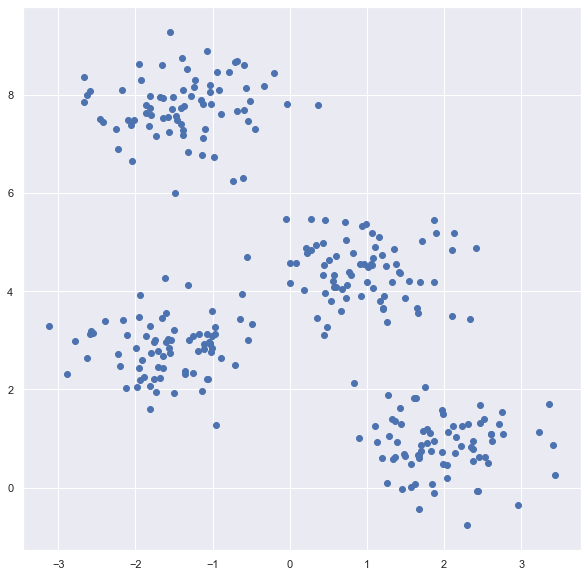

In [2]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.6, random_state=0)
print(X.shape)
fig, ax = plt.subplots(1, figsize=(10,10))
print(X.shape)
#X[:,0] bedeutet: Für alle Zeilen die erste Spalte
#X[:,1] bedeutet: Für alle Zeilen die zweite Spalte
#Funktioniert quasi wie eine For-Schleife
ax.scatter(X[:, 0], X[:, 1]);

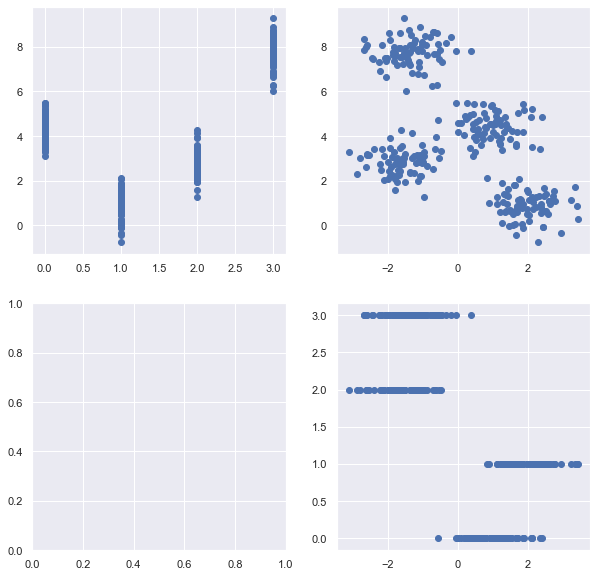

In [4]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].scatter(y_true, X[:,1]);
axs[1,1].scatter(X[:,0], y_true);
axs[0,1].scatter(X[:,0], X[:,1]);

Man sieht schon mit bloßem Auge vier Cluster.

## Fertiger Algorithmus in Scikit-Learn

Wir nutzen nun den k-Means Algorithmus von Scikit-learn. Das Muster ist dabei immer gleich:

- zunächst wählt man ein Modell
- und ruft dann die `.fit`-Methode, um das Modell zu trainieren
- schließlich wendet man mit der `.predict`-Methode die Modell auf an

Hier könnten wir auch die Kurzform `fit_predict` verwenden, wir arbeiten ja bei `fit` und `predict` mit dem gleichen Datensätzen.

Hier ist die [Doku zu KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)


In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
# Fit = Trainieren des Modells
kmeans.fit(X)
# Predict = Anwenden des Modells
y_kmeans = kmeans.predict(X)

Wir können das Ergebnis visualisieren - die großen roten Punkte zeigen die Zenter der Cluster an:

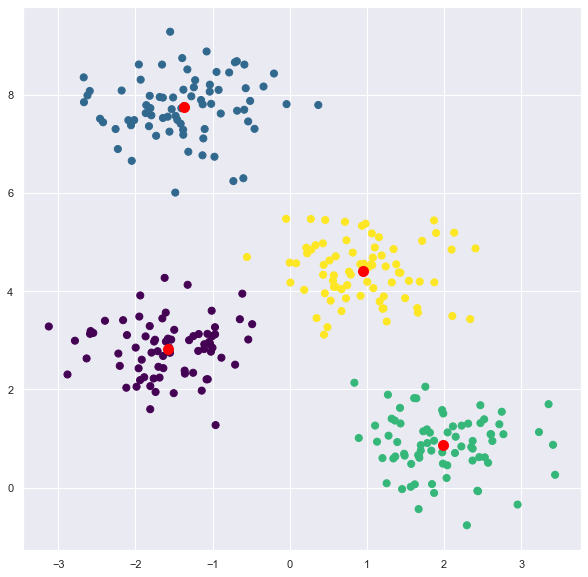

In [6]:
centers = kmeans.cluster_centers_

fig, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=100);


In [7]:
print("Der Algorithmus benötigte {} Iterationen".format(kmeans.n_iter_))
# Inertia ist ein Maß zum vergleichen verschiedener Algorithmen
print("Inertia: {}".format(kmeans.inertia_))

Der Algorithmus benötigte 2 Iterationen
Inertia: 212.00599621083478


## Implementierung

Der Algorithmus ist einfach genug, dass wir ihn in wenigen Zeilen selbst schreiben können:

In [3]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. wähle zufällige Zentren:
    rng = np.random.default_rng(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    n_iter = 0
    while True:
        # Färbe entsprechend dem nächtsgelegenen Zentrum ein
        labels = pairwise_distances_argmin(X, centers)

        # Ermittle neue Zentren als Mittelpunkt des Clusters
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

        # Prüfe, ob fertig
        if np.all(centers == new_centers):
            break
        centers = new_centers
        n_iter = n_iter + 1

    inertia = 0
    for x in X:
        closestDistance = float("inf")
        for y in centers:
            d = (x-y).T.dot(x-y) # Vektor-Äquivalent von Euklidischer Norm zum Quadrat
            if d < closestDistance:
                closestDistance = d
        inertia += closestDistance
        
    return centers, labels, n_iter, inertia

centers, labels, n_iter, inertia = find_clusters(X, 4)

print("Der Algorithmus benötigte {} Iterationen".format(n_iter))
print("Inertia: {}".format(inertia))

Der Algorithmus benötigte 3 Iterationen
Inertia: 212.00599621083472


Schauen wir uns das Ergebnis an:

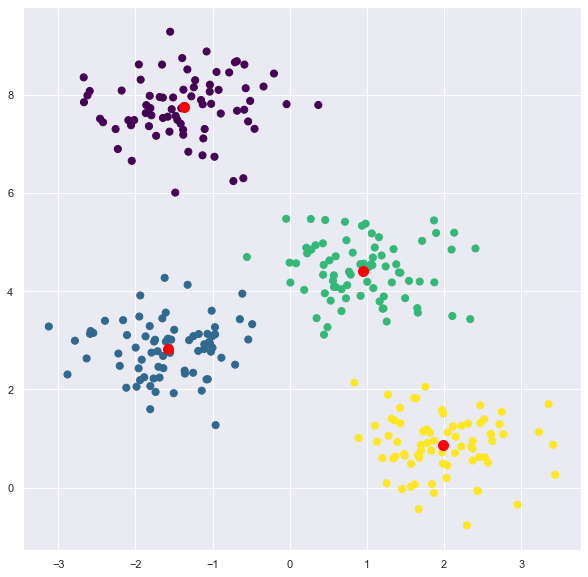

In [9]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=100);


Wir können uns das auch interaktiv anschauen:

In [11]:
from ipywidgets import interact
from sklearn.metrics import pairwise_distances_argmin
import ipywidgets as widgets

def plot_kmeans_interactive(min_clusters=1, max_clusters=6):
    def plot_points(ax, X, labels, n_clusters):
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', vmin=0, vmax=n_clusters - 1)

    def plot_centers(ax, centers):
        ax.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c=np.arange(centers.shape[0]),
                    s=200, cmap='viridis')
        ax.scatter(centers[:, 0], centers[:, 1], marker='o', c='red', s=100)

    def _kmeans_step(frame=0, n_clusters=4, rseed=2):
        labels = np.zeros(X.shape[0])
        rng = np.random.default_rng(rseed)
        i = rng.permutation(X.shape[0])[:n_clusters]
        centers = X[i]

        nsteps = frame // 3

        for i in range(nsteps + 1):
            old_centers = centers
            if i < nsteps or frame % 3 > 0:
                labels = pairwise_distances_argmin(X, centers)

            if i < nsteps or frame % 3 > 1:
                centers = np.array([X[labels == j].mean(0)
                                    for j in range(n_clusters)])
                nans = np.isnan(centers)
                centers[nans] = old_centers[nans]

        # plot the data and cluster centers
        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.set_xlim(-6, 6)
        ax.set_ylim(-2, 10)

        plot_points(ax, X, labels, n_clusters)
        plot_centers(ax, old_centers)

        # plot new centers if third frame
        if frame % 3 == 2:
            for i in range(n_clusters):
                ax.annotate('', centers[i], old_centers[i],
                             arrowprops=dict(arrowstyle='->', linewidth=3, color='yellow'))
            plot_centers(ax, centers)

        if frame == 0:
            ax.set_title("Initialisierung: Setze die Zentren zufällig")
        elif frame % 3 == 1:
            ax.set_title("1. Färbe die Punkte entsprechend dem nächsten Zentrum ein")
        elif frame % 3 == 2:
            ax.set_title("2. Setze die Zentren auf den Cluster-Durchschnitt")
        elif frame % 3 == 0 and frame > 0:
            ax.set_title("Ergebnis: Neue Positionen der Zentren")

    return interact(_kmeans_step, frame=widgets.IntSlider(min=0, max=100, step=1, value=0),
                    n_clusters=[1, 2, 3, 4, 5, 6, 15],
                    rseed=[2,4])

plot_kmeans_interactive();


interactive(children=(IntSlider(value=0, description='frame'), Dropdown(description='n_clusters', index=3, opt…

## Limitierungen des k-Means Algorithmus

### Die Anzahl der Cluster muss im Vorfeld gewählt werden

Wie man sieht ist die Wahl von k ganz entscheidend für eine saubere Trennung der Cluster.

- Zu kleines k differenziert die Cluster ggf. nicht ausreichend.
- Zu großes k trennt ggf. willkürlich Cluster auf.

### Lösung ist nicht unbedingt die global beste Lösung

Das Verfahren konvergiert zwar garantiert, allerdings nicht notwendigerweise zur global optimalen Lösung.

Hier wirkt sich ganz entscheidend die anfängliche Anordnung der Zentren aus. Daher wird die Berechnung
in der Praxis mehrere Male mit jeweils zufällig gewählten Anfangszentren wiederholt.

Scikit-Learn macht das defaultmäßig 10 mal, gesteuert über den Parameter `n_init`.

Inertia: 528.4253797545108


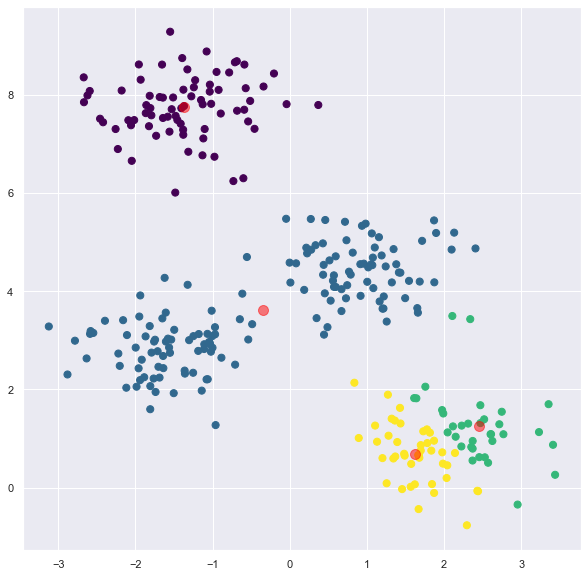

In [11]:
centers, labels, n_iter, inertia = find_clusters(X, n_clusters=4, rseed=4)

fig, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5);
print("Inertia: {}".format(inertia))

Wir sehen hier, dass für dieses suboptimale Ergebnis die Inertia wesentlich größer ist.

Können wir das auch verwenden, um unterschiedliche Cluster-Anzahlen zu bewerten?

In [12]:
for n in np.append(np.arange(10),299):
    k = n + 1
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    print('Anzahl Cluster: {} - Inertia: {}'.format(k, kmeans.inertia_))


Anzahl Cluster: 1 - Inertia: 2812.137595303234
Anzahl Cluster: 2 - Inertia: 1190.7823593643445
Anzahl Cluster: 3 - Inertia: 546.8911504626296
Anzahl Cluster: 4 - Inertia: 212.00599621083478
Anzahl Cluster: 5 - Inertia: 193.35163306918983
Anzahl Cluster: 6 - Inertia: 171.00503364983393
Anzahl Cluster: 7 - Inertia: 152.94295382573517
Anzahl Cluster: 8 - Inertia: 137.57110814130755
Anzahl Cluster: 9 - Inertia: 125.0640373980984
Anzahl Cluster: 10 - Inertia: 112.54093121079327
Anzahl Cluster: 300 - Inertia: 0.0


Nein. Das ist auch einleuchtend, wenn man sich überlegt, dass bei zunehmenden Clusteranzahlen die Wege
der Punkte zu ihren Zentren natürlich abnimmt.

Wenn jeder Punkt sein eigenes Cluster ist, dann ist Inertia = 0.

### Langsam, bei großen Datensets

Da jede Iteration von k-Means auf jeden Punkt im Datensatz zugreifen muss, kann der Algorithmus
relativ langsam sein, wenn die Anzahl der Stichproben wächst. Sie könnten sich fragen, ob diese
Anforderung, alle Daten bei jeder Iteration zu verwenden, gelockert werden kann;
beispielsweise könnten Sie einfach eine Teilmenge der Daten verwenden, um die Clusterzentren
bei jedem Schritt zu aktualisieren.

Dies ist die Idee hinter den batchbasierten k-Means-Algorithmen, von denen eine Form
in `sklearn.cluster.MiniBatchKMeans` implementiert ist. Die Schnittstelle hierfür ist die
gleiche wie für Standard-K-Means.

### Limitiert auf lineare Cluster Grenzen

Die Grenze zwischen zwei Clustern ist immer eine Gerade, daher hat der Algorithmus Probleme, wenn
die Cluster kompliziertere Formen haben. Die Grenzen eines Clusters sind Linienabschnitte, sie bilden ein Voronoi:

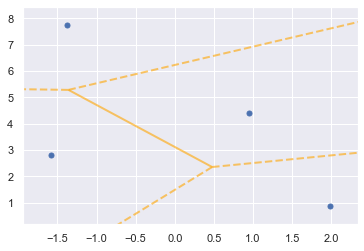

In [13]:
from scipy.spatial import Voronoi, voronoi_plot_2d

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

centers = kmeans.cluster_centers_
vor = Voronoi(centers)
voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=10);


Diese Form limitiert natürlich, was KMeans als Cluster differenzieren kann. Hier ein Beispiel, an dem KMeans scheitern muss:

In [14]:
from sklearn.datasets import make_moons, make_circles

X_1, y = make_moons(200, noise=.05, random_state=0)
X_2, y = make_moons(200, noise=.05, random_state=0)
X_strange = np.vstack([X_1, 2 + X_2])
print(X_strange.shape)

kmeans = KMeans(4, random_state=0)
kmeans.fit(X_strange)
y_means = kmeans.predict(X_strange)
centers = kmeans.cluster_centers_
print('Inertia: {}'.format(kmeans.inertia_))

(400, 2)
Inertia: 159.32468632955755


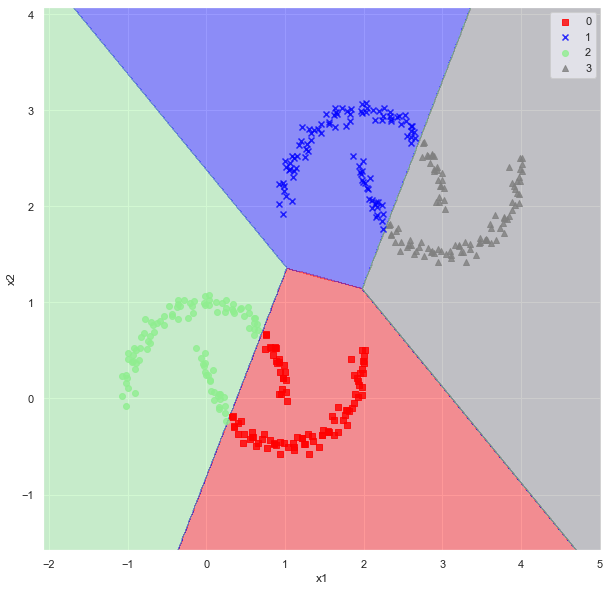

In [15]:
import DecisionPlot

DecisionPlot.plot_decision_surface(X_strange, y_means, kmeans);

## Alternative Algorithmen

- Gaussian mixture models
- Algorithmen, die Anzahl der Cluster selber wählen können:
    - DBSCAN
    - mean-shift
    - affinity propagation
    - ...